{{ badge }}

## Fine-tuning your first Transformer!

In this notebook we'll take a look at fine-tuning a multilingual Transformer model called [XLM-RoBERTa](https://huggingface.co/xlm-roberta-base) for text classification. By the end of this notebook you should know how to:

* Load and process a dataset from the Hugging Face Hub
* Create a baseline with the zero-shot classification pipeline
* Fine-tune and evaluate pretrained model on your data
* Push a model to the Hugging Face Hub

Let's get started!

## Setup

If you're running this notebook on Google Colab or locally, you'll need a few dependencies installed. You can install them with `pip` as follows:

In [ ]:
#! pip install datasets transformers sentencepiece

To be able to share your model with the community and generate results like the one shown in the picture below via the inference API, there are a few more steps to follow.

First you have to store your authentication token from the Hugging Face website (sign up [here](https://huggingface.co/join) if you haven't already!) then execute the following cell and input your username and password:

In [3]:
from huggingface_hub import notebook_login

notebook_login()

Then you need to install Git-LFS. Uncomment and execute the following cell:

In [ ]:
# !apt install git-lfs

## The dataset

In this notebook we'll be using the 🤗 Datasets to load and preprocess our data. If you're new to this library, check out the video below to get some additional context:

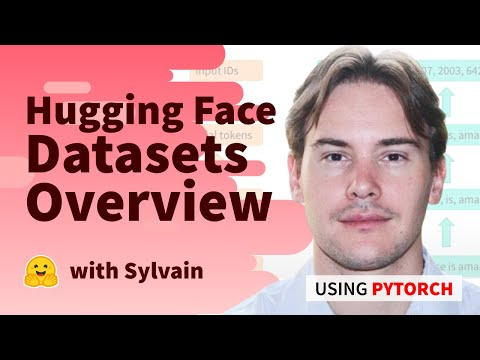

In [1]:
from IPython.display import YouTubeVideo

YouTubeVideo("_BZearw7f0w", width=600, height=400)

In this tutorial we'll use the [Multilingual Amazon Reviews Corpus](https://huggingface.co/datasets/amazon_reviews_multi) (or MARC for short). This is a large-scale collection of Amazon product reviews in several languages: English, Japanese, German, French, Spanish, and Chinese. 

We can download the dataset from the Hugging Face Hub with the 🤗 Datasets library, but first let's take a look at the available subsets (also called configs):

In [3]:
from datasets import get_dataset_config_names

dataset_name = "amazon_reviews_multi"
langs = get_dataset_config_names(dataset_name)
langs

['all_languages', 'de', 'en', 'es', 'fr', 'ja', 'zh']

Okay, we can see the language codes associated with each language, as well as an `all_languages` subset which presumably concatenates all the languages together. Let's begin by downloading the German subset with the `load_dataset()` function from 🤗 Datasets:

In [4]:
from datasets import load_dataset

marc_de = load_dataset(path=dataset_name, name="de")
marc_de

Reusing dataset amazon_reviews_multi (/data/.cache/hf/datasets/amazon_reviews_multi/de/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
        num_rows: 200000
    })
    validation: Dataset({
        features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
        num_rows: 5000
    })
    test: Dataset({
        features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
        num_rows: 5000
    })
})

One cool feature of 🤗 Datasets is that `load_dataset()` will cache the files at `~/.cache/huggingface/dataset/`, so you won't need to re-download the dataset the next time your run the notebook. We can see that `german_dataset` is a `DatasetDict` object which is similar to a Python dictionary, with each key corresponding to a different split. 

We can access one ot these splits just like an ordinary dictionary:

In [5]:
train_ds = marc_de["train"]
train_ds

Dataset({
    features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
    num_rows: 200000
})

This returns a `Dataset` object which behaves like a Python container, so we can query its length:

In [6]:
len(train_ds)

200000

or access a single example by its index:

In [7]:
train_ds[0]

{'language': 'de',
 'product_category': 'sports',
 'review_body': 'Armband ist leider nach 1 Jahr kaputt gegangen',
 'review_id': 'de_0203609',
 'stars': 1,
 'reviewer_id': 'reviewer_de_0267719',
 'product_id': 'product_de_0865382',
 'review_title': 'Leider nach 1 Jahr kaputt'}

This certainly looks like an Amazon product review (in this case the `review_body` text translates to "Bracelet is unfortunately broken after 1 year") and we can see the number of stars associated with the review, as well as some metadata like the language and product category. We can also see that a single row is represented as a dictionary, where the keys are the same as the column names:

In [8]:
train_ds.column_names

['review_id',
 'product_id',
 'reviewer_id',
 'stars',
 'review_body',
 'review_title',
 'language',
 'product_category']

We can also access several rows with a slice:

In [9]:
train_ds[:3]

{'review_id': ['de_0203609', 'de_0559494', 'de_0238777'],
 'product_id': ['product_de_0865382',
  'product_de_0678997',
  'product_de_0372235'],
 'reviewer_id': ['reviewer_de_0267719',
  'reviewer_de_0783625',
  'reviewer_de_0911426'],
 'stars': [1, 1, 1],
 'review_body': ['Armband ist leider nach 1 Jahr kaputt gegangen',
  'In der Lieferung war nur Ein Akku!',
  'Ein Stern, weil gar keine geht nicht. Es handelt sich um gebraucht Waren, die Stein haben so ein Belag drauf, wo man sich dabei denken kann, dass jemand schon die benutzt und nicht Mal richtig gewaschen. Bei ein paar ist die Qualität Mangelhaft, siehe Bild. Ein habe ich ausprobiert, richtig gewaschen, dann verfärbt sich..... Wärme halt nicht lange. Deswegen wird es zurückgeschickt.'],
 'review_title': ['Leider nach 1 Jahr kaputt',
  'EINS statt ZWEI Akkus!!!',
  'Achtung Abzocke'],
 'language': ['de', 'de', 'de'],
 'product_category': ['sports', 'home_improvement', 'drugstore']}

and note that now we get a list of values for each column. This is because 🤗 Datasets is based on Apache Arrow, which defines a typed columnar format that is very memory efficient. We can see the types that are used to represent our dataset by accessing the `features` attribute:

In [10]:
train_ds.features

{'review_id': Value(dtype='string', id=None),
 'product_id': Value(dtype='string', id=None),
 'reviewer_id': Value(dtype='string', id=None),
 'stars': Value(dtype='int32', id=None),
 'review_body': Value(dtype='string', id=None),
 'review_title': Value(dtype='string', id=None),
 'language': Value(dtype='string', id=None),
 'product_category': Value(dtype='string', id=None)}

Now that we've had a quick look at the objects in 🤗 Datasets, let's explore the data in more detail by using our favourite tool - Pandas!

## From Datasets to DataFrames and back

🤗 Datasets is designed to be interoperable with libraries like Pandas, as well as NumPy, PyTorch, TensorFlow, and JAX. To enable the conversion between various third-party libraries, 🤗 Datasets provides a Dataset.set_format() function. This function only changes the output format of the dataset, so you can easily switch to another format without affecting the underlying data format which is Apache Arrow. The formatting is done in-place, so let’s convert our dataset to Pandas and look at a random sample:

In [11]:
from IPython.display import display, HTML

marc_de.set_format("pandas")
df = marc_de["train"][:]
# Create a random sample
sample = df.sample(n=5, random_state=42)
display(HTML(sample.to_html()))

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
119737,de_0970901,product_de_0712478,reviewer_de_0308094,3,Ist ok ...blondierung quillt schnell auf,Ok,de,beauty
72272,de_0042217,product_de_0734686,reviewer_de_0904358,2,Kein typischer Geruch oder Geschmack von einem Ghee! Ich würde es nicht wieder kaufen oder weiter empfehlen. Konkurrenz Produkt fand ich besser.,Kein typischer Geruch oder Geschmack von einem Ghee !,de,grocery
158154,de_0278932,product_de_0388890,reviewer_de_0940030,4,Dieses Buch hat mir sehr geholfen mit dem ersten Schlupf und der weiteren Aufzucht. Kann ich nur weiter empfehlen.,Sehr hilfreich,de,book
65426,de_0737352,product_de_0560586,reviewer_de_0632435,2,"super Schale, wunderschön, gutes Produkt ABER Der Saugnapf geht von der Schale runter, da die Maße des Saugnapf Ringes nicht passen. Man muss aufpassen dass man den nicht dauernd neu aufsetzen muss.",der Saugnapf hält nicht,de,baby_product
30074,de_0455430,product_de_0375951,reviewer_de_0482228,1,"Artikel ist niemals angekommen, habe ihn aber bezahlt! Und dann steht noch dort ich hätte unterschrieben, als er angeblich angekommen sei! null Sterne! Unglaublich 😒",Artikel ist niemals angekommen!!,de,book


We can see that the column headers are the same as we saw in the Arrow format and from the reviews we can see that negative reviews are associated with a lower star rating. Since we're now dealing with a `pandas.DataFrame` we can easily query our dataset. For example, let's see what the distribution of reviews per product category looks like: 

In [12]:
df["product_category"].value_counts()

home                        26063
wireless                    19964
sports                      13748
home_improvement            12408
apparel                     10178
toy                          9781
pc                           8577
drugstore                    8075
lawn_and_garden              7426
beauty                       7162
electronics                  7114
other                        6460
furniture                    6334
kitchen                      5787
automotive                   5321
pet_products                 5028
book                         4927
office_product               4343
baby_product                 4070
shoes                        3568
luggage                      3256
digital_video_download       2970
personal_care_appliances     2836
grocery                      2737
digital_ebook_purchase       2720
jewelry                      2380
camera                       1906
watch                        1706
video_games                  1219
industrial_sup

Okay, the `home`, `wireless`, and `sports` categories seem to be the most popular. How about the distribution of star ratings?

In [13]:
df["stars"].value_counts()

1    40000
2    40000
3    40000
4    40000
5    40000
Name: stars, dtype: int64

In this case we can see that the dataset is balanced across each star rating, which will make it somewhat easier to evaluate our models on. Imbalanced datasets are much more common in the real-world and in these cases some additional tricks like up- or down-sampling are usually needed.

Now that we've got a rough idea about the kind of data we're dealing with, let's reset the output format from `pandas` back to `arrow`:

In [14]:
marc_de.reset_format()

## Filtering for a product category

Although we could go ahead and fine-tune a Transformer model on the whole set of 200,000 German reviews, this will take several hours on a single GPU. So instead, we'll focus on fine-tuning a model for a single product category! In 🤗 Datasets, we can filter data very quickly by using the `Dataset.filter()` method. This method expects a function that returns Boolean values, in our case `True` if the `product_category` matches the chosen category and `False` otherwise. Here's one way to implement this, and we'll pick the `sports` category as the domain to train on:

In [15]:
product_category = "sports"

def filter_for_product(example, product_category=product_category):
    return example["product_category"] == product_category

Now when we pass `filter_for_product()` to `Dataset.filter()` we get a filtered dataset:

In [16]:
product_dataset = marc_de.filter(filter_for_product)
product_dataset

Loading cached processed dataset at /data/.cache/hf/datasets/amazon_reviews_multi/de/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609/cache-415aaa5af094e2c4.arrow
Loading cached processed dataset at /data/.cache/hf/datasets/amazon_reviews_multi/de/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609/cache-60d769fb1e7b4f2f.arrow
Loading cached processed dataset at /data/.cache/hf/datasets/amazon_reviews_multi/de/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609/cache-9618290228399c16.arrow


DatasetDict({
    train: Dataset({
        features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
        num_rows: 13748
    })
    validation: Dataset({
        features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
        num_rows: 339
    })
    test: Dataset({
        features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
        num_rows: 329
    })
})

Yep, this looks good - we have 13,748 reviews in the train split which agrees the number we saw in the distribution of categories earlier. Let's do a quick sanity check by taking a look at a few samples. Here 🤗 Datasets provides `Dataset.shuffle()` and `Dataset.select()` functions that we can chain to get a random sample:

In [17]:
product_dataset["train"].shuffle(seed=42).select(range(3))[:]

Loading cached shuffled indices for dataset at /data/.cache/hf/datasets/amazon_reviews_multi/de/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609/cache-34cfe66dac005389.arrow


{'review_id': ['de_0592068', 'de_0659764', 'de_0617399'],
 'product_id': ['product_de_0646545',
  'product_de_0628607',
  'product_de_0596523'],
 'reviewer_id': ['reviewer_de_0065351',
  'reviewer_de_0938057',
  'reviewer_de_0996678'],
 'stars': [5, 2, 3],
 'review_body': ['Dieses aufblasbare Sofa ist sehr einfach aufzubauen (einfach in Wind halten) und leicht wieder einzupacken. Es war gut verpackt (eine Tasche mit Tragegurt war dabei), hat Aufbewahrungsmöglichkeiten an der Rechten Seite und einen Hering zum Befestigen am oberen Rand. Es ist sehr bequem und die Preis/Leistung ist einfach super! Ich kann es wirklich nur empfehlen :)',
  'Leider nach ca. 1 Jahr ist die Schnalle abgerissen. Schade!!!',
  'An sich ist das X-Bike nicht schlecht bis auf die Verarbeitung vom Computer. Sehr zu bemängeln habe ich aber die Pedalen bzw. Die Kugellager darin, am zweiten Tag und nach circa 30 km haben sich die Kugellager aufgelöst. Pedale lassen dich nicht mehr drehen.'],
 'review_title': ['Sehr b

Okay, now that we have our corpus of sports reviews, let's do one last bit of data preparation: creating label mappings from star ratings to human readable strings.

## Mapping the labels

During training, 🤗 Transformers expects the labels to be ordered, starting from 0 to N. But we've seen that our star ratings range from 1-5, so let's fix that. While we're at it, we'll create a mapping between the label IDs and names, which will be handy later on when we want to run inference with our model. First we'll define the label mapping from ID to name:

In [18]:
label_names = ["terrible", "poor", "ok", "good", "great"]
id2label = {idx:label for idx, label in enumerate(label_names)}
id2label

{0: 'terrible', 1: 'poor', 2: 'ok', 3: 'good', 4: 'great'}

We can then apply this mapping to our whole dataset by using the `Dataset.map()` method. Similar to the `Dataset.filter()` method, this one expects a function which receives examples as input, but returns a Python dictionary as output. The keys of the dictionary correspond to the columns, while the values correspond to the column entries. The following function creates two new columns:

* A `labels` column which is the star rating shifted down by one
* A `label_name` column which provides a nice string for each rating

In [19]:
def map_labels(example):
    # Shift labels to start from 0
    label_id = example["stars"] - 1
    return {"labels": label_id, "label_name": id2label[label_id]}

To apply this mapping, we simply feed it to `Dataset.map` as follows:

In [20]:
product_dataset = product_dataset.map(map_labels)
# Peek at the first example
product_dataset["train"][0]

Loading cached processed dataset at /data/.cache/hf/datasets/amazon_reviews_multi/de/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609/cache-3305e19e1599db7f.arrow
Loading cached processed dataset at /data/.cache/hf/datasets/amazon_reviews_multi/de/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609/cache-ff534f940f83173d.arrow
Loading cached processed dataset at /data/.cache/hf/datasets/amazon_reviews_multi/de/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609/cache-9cc9183bef8d8635.arrow


{'language': 'de',
 'label_name': 'terrible',
 'product_category': 'sports',
 'review_body': 'Armband ist leider nach 1 Jahr kaputt gegangen',
 'review_id': 'de_0203609',
 'stars': 1,
 'reviewer_id': 'reviewer_de_0267719',
 'product_id': 'product_de_0865382',
 'review_title': 'Leider nach 1 Jahr kaputt',
 'labels': 0}

Great, it works! We'll also need the reverse label mapping later, so let's define it here: 

In [21]:
label2id = {v:k for k,v in id2label.items()}

## Creating a baseline

A good practice when you're doing any sort of machine learning is to create a baseline model you can compare against. For text classification problems, a quick way to start is by using the zero-shot classification pipeline, which allows you to easily customise the number classes without having to train a model from scratch. If you want some more informatoin about the pipelines in Transformers, check out the following video:

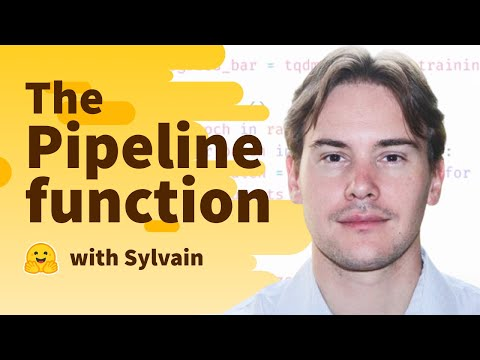

In [2]:
YouTubeVideo("tiZFewofSLM", width=600, height=400)

Let's load one of the multilingual checkpoints from the Hub:

In [24]:
from transformers import pipeline 

# `device` >= 0 places the model on the GPU
zeroshot_classifier = pipeline("zero-shot-classification", model="vicgalle/xlm-roberta-large-xnli-anli", device=0)

Downloading:   0%|          | 0.00/734 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.09G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

With this pipeline, we simply need to pass some text and the label names in the `candidate_labels` argument:

In [25]:
zeroshot_classifier("Dieser Tennisschläger ist perfekt!", candidate_labels=label_names)

{'sequence': 'Dieser Tennisschläger ist perfekt!',
 'labels': ['great', 'good', 'ok', 'poor', 'terrible'],
 'scores': [0.41970810294151306,
  0.38007867336273193,
  0.19984789192676544,
  0.00018881850701291114,
  0.00017650889640208334]}

Now that we have our zero-shot pipeline, we'll use `Dataset.map()` to apply it to each example in the validation set. For that we'll need a small function to create a new column of predictions:

In [34]:
def compute_zeroshot_preds(examples):
    preds = zeroshot_classifier(examples["review_body"], candidate_labels=label_names)
    label_pred = label2id[preds["labels"][0]]
    return {"zeroshot_prediction": label_pred}

In [35]:
zeroshot_preds = product_dataset["validation"].map(compute_zeroshot_preds)

  0%|          | 0/339 [00:00<?, ?ex/s]

/home/lewis/miniconda3/envs/hf/lib/python3.9/site-packages/transformers/pipelines/base.py:899: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


Now that we've got some predictions, it's time to evaluate them! In the [MARC paper](https://arxiv.org/pdf/2010.02573.pdf), the authors point out that one should use the mean absolute error (MAE) for star ratings because:

> star ratings for each review are ordinal, and a 2-star prediction for a 5-star review should be penalized more heavily than a 4-star prediction for a 5-star review.

We'll take the same approach here and we can get the metric easily from Scikit-learn as follows:

In [33]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(zeroshot_preds["labels"], zeroshot_preds["zeroshot_prediction"])

For reference, the MARC paper quotes MAE results from mBERT in the range of 0.5-0.7. Let's see if we can get close to that with XLM-RoBERTa!

## From text to tokens

Like other machine learning models, Transformers expect their inputs in the form of numbers (not strings) and so some form of preprocessing is required. For NLP, this preprocessing step is called _tokenization_. Tokenization converts strings into atomic chunks called tokens, and these tokens are subsequently encoded as numerical vectors. 

For more information about tokenizers, check out the following video:

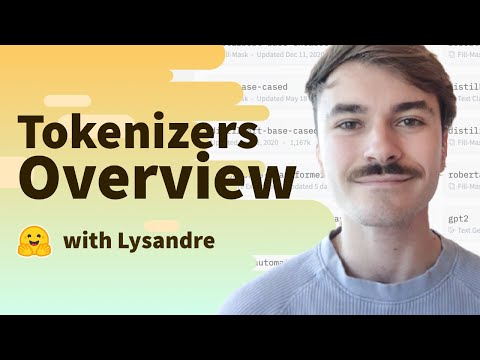

In [3]:
YouTubeVideo("VFp38yj8h3A", width=600, height=400)

Each pretrained model comes with its own tokenizer, so to get started let's download the tokenizer of XLM-RoBERTa from the Hub:

In [22]:
from transformers import AutoTokenizer

model_checkpoint = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

The tokenizer has a few interesting attributes such as the vocabulary size:

In [23]:
tokenizer.vocab_size

250002

This tells us that XLM-R has 250,002 tokens that is can use to represent text with. Some of the tokens are called _special tokens_ to indicate whether a token is the start or end of a sentence, or corresponds to the mask that is associated with language modeling. Here's what the special tokens look like for XLM-R:

In [25]:
tokenizer.special_tokens_map

{'bos_token': '<s>',
 'eos_token': '</s>',
 'unk_token': '<unk>',
 'sep_token': '</s>',
 'pad_token': '<pad>',
 'cls_token': '<s>',
 'mask_token': '<mask>'}

When you feed strings to the tokenizer, you'll get at least two fields (some models have more, depending on how they're trained):

* `input_ids`: These correspond to the numerical encodings that map each token to an integer
* `attention_mask`: This indicates to the model which tokens should be ignored when computing self-attention

Let's see how this works with a simple example. First we encode the string:

In [31]:
encoded_str = tokenizer("Guten Tag, mein Name ist Lewis")
encoded_str

{'input_ids': [0, 37410, 33, 4837, 4, 8172, 15757, 443, 77330, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

and then decode the input IDs to see the mapping explicitly:

In [33]:
for token in encoded_str["input_ids"]:
    print(token, tokenizer.decode([token]))

0 <s>
37410 Gut
33 en
4837 Tag
4 ,
8172 mein
15757 Name
443 ist
77330 Lewis
2 </s>


So to prepare our inputs, we simply need to apply the tokenizer to each example in our corpus. As before, we'll do this with `Dataset.map()` so let's write a simple function to do so:

In [34]:
def tokenize_reviews(examples):
    return tokenizer(examples["review_body"], truncation=True, max_length=180)

Here we've enabled truncation, so the tokenizer will cut any inputs that are longer than 180 tokens (which is the setting used in the MARC paper). With this function we can go ahead and tokenize the whole corpus:

In [35]:
tokenized_dataset = product_dataset.map(tokenize_reviews, batched=True)
tokenized_dataset

Loading cached processed dataset at /data/.cache/hf/datasets/amazon_reviews_multi/de/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609/cache-7c76818905c6886a.arrow
Loading cached processed dataset at /data/.cache/hf/datasets/amazon_reviews_multi/de/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609/cache-2a7fafc5fe9ed8ec.arrow
Loading cached processed dataset at /data/.cache/hf/datasets/amazon_reviews_multi/de/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609/cache-31f85c0c0b3e473c.arrow


DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'input_ids', 'label_name', 'labels', 'language', 'product_category', 'product_id', 'review_body', 'review_id', 'review_title', 'reviewer_id', 'stars'],
        num_rows: 13748
    })
    validation: Dataset({
        features: ['attention_mask', 'input_ids', 'label_name', 'labels', 'language', 'product_category', 'product_id', 'review_body', 'review_id', 'review_title', 'reviewer_id', 'stars'],
        num_rows: 339
    })
    test: Dataset({
        features: ['attention_mask', 'input_ids', 'label_name', 'labels', 'language', 'product_category', 'product_id', 'review_body', 'review_id', 'review_title', 'reviewer_id', 'stars'],
        num_rows: 329
    })
})

In [36]:
tokenized_dataset["train"][0]

{'language': 'de',
 'label_name': 'terrible',
 'input_ids': [0,
  33119,
  8262,
  443,
  35103,
  1561,
  106,
  7418,
  42567,
  3062,
  6,
  79659,
  2],
 'product_category': 'sports',
 'review_body': 'Armband ist leider nach 1 Jahr kaputt gegangen',
 'review_id': 'de_0203609',
 'stars': 1,
 'reviewer_id': 'reviewer_de_0267719',
 'product_id': 'product_de_0865382',
 'review_title': 'Leider nach 1 Jahr kaputt',
 'labels': 0,
 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

This looks good, so now let's load a pretrained model!

## Loading a pretrained model

To load a pretrained model from the Hub is quite simple: just select the appropriate `AutoModelForXxx` class and use the `from_pretrained()` function with the model checkpoint. In our case, we're dealing with 5 classes (one for each star) so to initialise the model we'll provide this information along with the label mappings:

In [46]:
from transformers import AutoModelForSequenceClassification

num_labels = 5
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels, label2id=label2id, id2label=id2label)

loading configuration file https://huggingface.co/xlm-roberta-base/resolve/main/config.json from cache at /data/.cache/hf/transformers/87683eb92ea383b0475fecf99970e950a03c9ff5e51648d6eee56fb754612465.ab95cf27f9419a99cce4f19d09e655aba382a2bafe2fe26d0cc24c18cf1a1af6
Model config XLMRobertaConfig {
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "terrible",
    "1": "poor",
    "2": "ok",
    "3": "good",
    "4": "great"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "good": 3,
    "great": 4,
    "ok": 2,
    "poor": 1,
    "terrible": 0
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "pos

These warnings are perfectly normal - they are telling us that the weights in the head of the network are randomly initialised and so we should fine-tune the model on a downstream task.

Now that we have a model, the next step is to initialise a `Trainer` that will take care of the training loop for us. Let's do that next.

## Creating a Trainer

To create a `Trainer`, we usually need a few basic ingredients:

* A `TrainingArguments` class to define all the hyperparameters
* A `compute_metrics` function to compute metrics during evaluation
* Datasets to train and evaluate on

For more information about the `Trainer` check out the following video:

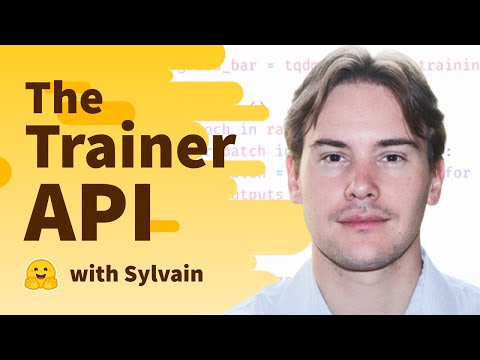

In [4]:
YouTubeVideo("nvBXf7s7vTI", width=600, height=400)

Let's start with the `TrainingArguments`:

In [41]:
from transformers import TrainingArguments

model_name = model_checkpoint.split("/")[-1]
batch_size = 16
num_train_epochs = 2
logging_steps = len(tokenized_dataset["train"]) // (batch_size * num_train_epochs)

args = TrainingArguments(
    output_dir=f"{model_name}-finetuned-marc",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_train_epochs,
    weight_decay=0.01,
    logging_steps=logging_steps,
    push_to_hub=True,
)

Here we've defined `output_dir` to save our checkpoints and tweaked some of the default hyperparameters like the learning rate and weight decay. The `push_to_hub` argument will push each checkpoint to the Hub automatically for us, so we can reuse the model at any point in the future!

Now that we've defined the hyperparameters, the next step is to define the metrics. As we did for the zero-shot pipeline, we'll use the mean absolute error, so we just wrap this logic in a simple function as follows:

In [45]:
from sklearn.metrics import mean_absolute_error

In [47]:
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {"MAE": mean_absolute_error(labels, predictions)}

With these ingredients we can now instantiate a `Trainer`:

In [48]:
from transformers import Trainer 

trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

/home/lewis/git/workshops/nlp-zurich/xlm-roberta-base-finetuned-marc is already a clone of https://huggingface.co/lewtun/xlm-roberta-base-finetuned-marc. Make sure you pull the latest changes with `repo.git_pull()`.


Note that here we've also provided the tokenizer to the `Trainer`: doing so will ensure that all of our examples are automatically padded to the longest example in each batch. This is needed so that matrix operations in the forward pass of the model can be computed. 

With our `Trainer`, it is then a simple matter to train the model:

In [49]:
trainer.train()

The following columns in the training set  don't have a corresponding argument in `XLMRobertaForSequenceClassification.forward` and have been ignored: label_name, language, product_category, review_body, review_id, stars, reviewer_id, product_id, review_title.
***** Running training *****
  Num examples = 13748
  Num Epochs = 2
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1720


Epoch,Training Loss,Validation Loss,Mae
1,1.033000,0.985195,0.507375
2,0.905700,0.985361,0.480826


The following columns in the evaluation set  don't have a corresponding argument in `XLMRobertaForSequenceClassification.forward` and have been ignored: label_name, language, product_category, review_body, review_id, stars, reviewer_id, product_id, review_title.
***** Running Evaluation *****
  Num examples = 339
  Batch size = 16
Saving model checkpoint to xlm-roberta-base-finetuned-marc/checkpoint-860
Configuration saved in xlm-roberta-base-finetuned-marc/checkpoint-860/config.json
Model weights saved in xlm-roberta-base-finetuned-marc/checkpoint-860/pytorch_model.bin
tokenizer config file saved in xlm-roberta-base-finetuned-marc/checkpoint-860/tokenizer_config.json
Special tokens file saved in xlm-roberta-base-finetuned-marc/checkpoint-860/special_tokens_map.json
tokenizer config file saved in xlm-roberta-base-finetuned-marc/tokenizer_config.json
Special tokens file saved in xlm-roberta-base-finetuned-marc/special_tokens_map.json
The following columns in the evaluation set  don't ha

TrainOutput(global_step=1720, training_loss=1.0193121623161228, metrics={'train_runtime': 412.588, 'train_samples_per_second': 66.643, 'train_steps_per_second': 4.169, 'total_flos': 1969525631983536.0, 'train_loss': 1.0193121623161228, 'epoch': 2.0})

Nice, with just a few mintues of training, we've managed to halve our error compared to the zero-shot baseline! After training is complete, we can push the commits to our repository on the Hub:

In [ ]:
trainer.push_to_hub(commit_message="Training complete!")

Saving model checkpoint to xlm-roberta-base-finetuned-marc
Configuration saved in xlm-roberta-base-finetuned-marc/config.json
Model weights saved in xlm-roberta-base-finetuned-marc/pytorch_model.bin
tokenizer config file saved in xlm-roberta-base-finetuned-marc/tokenizer_config.json
Special tokens file saved in xlm-roberta-base-finetuned-marc/special_tokens_map.json
Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 32.0k/1.04G [00:00<?, ?B/s]

Upload file runs/Oct15_19-59-11_vorace/events.out.tfevents.1634320897.vorace: 100%|##########| 4.93k/4.93k [00…

To https://huggingface.co/lewtun/xlm-roberta-base-finetuned-marc
   7308cc1..5b879d2  main -> main

Dropping the following result as it does not have all the necessary field:
{'task': {'name': 'Text Classification', 'type': 'text-classification'}, 'dataset': {'name': 'amazon_reviews_multi', 'type': 'amazon_reviews_multi', 'args': 'de'}}
To https://huggingface.co/lewtun/xlm-roberta-base-finetuned-marc
   5b879d2..a6ab0d4  main -> main



'https://huggingface.co/lewtun/xlm-roberta-base-finetuned-marc/commit/5b879d262ec86ee4cbfd23f40f733ae5edb9c7f6'

## Evaluating cross-lingual transfer

Now that we're fine-tuned our model on a German subset, we can evaluate its ability to transfer to other languages. To do so, we'll load the validation set in a given language, apply the same filtering and preprocessing that we did for the German subset, and finally use `Trainer.evaluate()` to compute the metrics. The following function does the trick: 

In [52]:
def evaluate_corpus(lang):
    # Load the language subset
    dataset = load_dataset(dataset_name, lang, split="validation")
    # Filter for the `sports` product category
    product_dataset = dataset.filter(filter_for_product)
    # Map and create label columns
    product_dataset = product_dataset.map(map_labels)
    # Tokenize the inputs
    tokenized_dataset = product_dataset.map(tokenize_reviews, batched=True)
    # Generate predictions and metrics
    preds = trainer.evaluate(eval_dataset=tokenized_dataset)
    return {"MAE": preds["eval_MAE"]}

Let's start with English (for reference our MAE on German was around 0.5):

In [53]:
evaluate_corpus("en")

Reusing dataset amazon_reviews_multi (/data/.cache/hf/datasets/amazon_reviews_multi/en/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609)


  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/225 [00:00<?, ?ex/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

The following columns in the evaluation set  don't have a corresponding argument in `XLMRobertaForSequenceClassification.forward` and have been ignored: label_name, language, product_category, review_body, review_id, stars, reviewer_id, product_id, review_title.
***** Running Evaluation *****
  Num examples = 225
  Batch size = 16


{'MAE': 0.52}

Not bad! Our fine-tuned German model is able to transfer to English at roughly the same performance. How about French?

In [54]:
evaluate_corpus("fr")

Reusing dataset amazon_reviews_multi (/data/.cache/hf/datasets/amazon_reviews_multi/fr/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609)


  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/210 [00:00<?, ?ex/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

The following columns in the evaluation set  don't have a corresponding argument in `XLMRobertaForSequenceClassification.forward` and have been ignored: label_name, language, product_category, review_body, review_id, stars, reviewer_id, product_id, review_title.
***** Running Evaluation *****
  Num examples = 210
  Batch size = 16


{'MAE': 0.5142857142857142}

Nice, this is very similar too! This shows the great power of multilingual models - provided your target language was included in the pretraining, there's a good chance you'll only need to tune and deploy a single model in production instead of running one per language. 

This wraps up our training and evaluation step - one last thing to try is seeing how we can interact with our model in a `pipeline`.

## Using your fine-tuned model

In [56]:
from transformers import pipeline 

finetuned_checkpoint = "lewtun/xlm-roberta-base-finetuned-marc"
classifier = pipeline("text-classification", model=finetuned_checkpoint)

https://huggingface.co/lewtun/xlm-roberta-base-finetuned-marc/resolve/main/config.json not found in cache or force_download set to True, downloading to /data/.cache/hf/transformers/tmpk7o8hszw


Downloading:   0%|          | 0.00/976 [00:00<?, ?B/s]

storing https://huggingface.co/lewtun/xlm-roberta-base-finetuned-marc/resolve/main/config.json in cache at /data/.cache/hf/transformers/708cb2dccaf4e0ade4961fd84072ddc367ccd3f880e82da2039b2f8b66d3364e.2b84791fe464e01eeffac0776c6630b7f5c8a4aa14a39ee1292d706acb9346f2
creating metadata file for /data/.cache/hf/transformers/708cb2dccaf4e0ade4961fd84072ddc367ccd3f880e82da2039b2f8b66d3364e.2b84791fe464e01eeffac0776c6630b7f5c8a4aa14a39ee1292d706acb9346f2
loading configuration file https://huggingface.co/lewtun/xlm-roberta-base-finetuned-marc/resolve/main/config.json from cache at /data/.cache/hf/transformers/708cb2dccaf4e0ade4961fd84072ddc367ccd3f880e82da2039b2f8b66d3364e.2b84791fe464e01eeffac0776c6630b7f5c8a4aa14a39ee1292d706acb9346f2
Model config XLMRobertaConfig {
  "_name_or_path": "xlm-roberta-base",
  "architectures": [
    "XLMRobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_a

Downloading:   0%|          | 0.00/1.04G [00:00<?, ?B/s]

storing https://huggingface.co/lewtun/xlm-roberta-base-finetuned-marc/resolve/main/pytorch_model.bin in cache at /data/.cache/hf/transformers/518a14fcd68b41e35e993f5db4923f9e07232e05205705d44830e769d2b21c2a.44a35cbe569be032eda61c76242ca7986aba02556a895ba6d8b1872bd3f32e6e
creating metadata file for /data/.cache/hf/transformers/518a14fcd68b41e35e993f5db4923f9e07232e05205705d44830e769d2b21c2a.44a35cbe569be032eda61c76242ca7986aba02556a895ba6d8b1872bd3f32e6e
loading weights file https://huggingface.co/lewtun/xlm-roberta-base-finetuned-marc/resolve/main/pytorch_model.bin from cache at /data/.cache/hf/transformers/518a14fcd68b41e35e993f5db4923f9e07232e05205705d44830e769d2b21c2a.44a35cbe569be032eda61c76242ca7986aba02556a895ba6d8b1872bd3f32e6e
All model checkpoint weights were used when initializing XLMRobertaForSequenceClassification.

All the weights of XLMRobertaForSequenceClassification were initialized from the model checkpoint at lewtun/xlm-roberta-base-finetuned-marc.
If your task is sim

Downloading:   0%|          | 0.00/398 [00:00<?, ?B/s]

storing https://huggingface.co/lewtun/xlm-roberta-base-finetuned-marc/resolve/main/tokenizer_config.json in cache at /data/.cache/hf/transformers/2f435776d6304cbf50eaead7e502081f62e039b6e109d72563f9d8c078dcc24c.b36482fbec4a714d3cfec99e0b05f4fdeec9e759090a78aed5597583a8b4783d
creating metadata file for /data/.cache/hf/transformers/2f435776d6304cbf50eaead7e502081f62e039b6e109d72563f9d8c078dcc24c.b36482fbec4a714d3cfec99e0b05f4fdeec9e759090a78aed5597583a8b4783d
https://huggingface.co/lewtun/xlm-roberta-base-finetuned-marc/resolve/main/sentencepiece.bpe.model not found in cache or force_download set to True, downloading to /data/.cache/hf/transformers/tmp2dlc3brm


Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

storing https://huggingface.co/lewtun/xlm-roberta-base-finetuned-marc/resolve/main/sentencepiece.bpe.model in cache at /data/.cache/hf/transformers/333fe27ab4d1569387cf119df3317f951e9033c50c47a7a8aae423a3db516bca.71e50b08dbe7e5375398e165096cacc3d2086119d6a449364490da6908de655e
creating metadata file for /data/.cache/hf/transformers/333fe27ab4d1569387cf119df3317f951e9033c50c47a7a8aae423a3db516bca.71e50b08dbe7e5375398e165096cacc3d2086119d6a449364490da6908de655e
https://huggingface.co/lewtun/xlm-roberta-base-finetuned-marc/resolve/main/tokenizer.json not found in cache or force_download set to True, downloading to /data/.cache/hf/transformers/tmphyz1pw99


Downloading:   0%|          | 0.00/8.66M [00:00<?, ?B/s]

storing https://huggingface.co/lewtun/xlm-roberta-base-finetuned-marc/resolve/main/tokenizer.json in cache at /data/.cache/hf/transformers/b426b5da2fb3b3de00fd86ff9ca65b0a30c01b5ae21340781e9105feac50baec.efb6ce620134b7ce68e8535339704894eb0fd7c4001a54ec8a6e7f6bd7bfd836
creating metadata file for /data/.cache/hf/transformers/b426b5da2fb3b3de00fd86ff9ca65b0a30c01b5ae21340781e9105feac50baec.efb6ce620134b7ce68e8535339704894eb0fd7c4001a54ec8a6e7f6bd7bfd836
https://huggingface.co/lewtun/xlm-roberta-base-finetuned-marc/resolve/main/special_tokens_map.json not found in cache or force_download set to True, downloading to /data/.cache/hf/transformers/tmprz1ku1wj


Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

storing https://huggingface.co/lewtun/xlm-roberta-base-finetuned-marc/resolve/main/special_tokens_map.json in cache at /data/.cache/hf/transformers/2e5241b31b3667f90c2cfebabc29f3d217f6c849cd02f2b25aff605db2ad81f2.a11ebb04664c067c8fe5ef8f8068b0f721263414a26058692f7b2e4ba2a1b342
creating metadata file for /data/.cache/hf/transformers/2e5241b31b3667f90c2cfebabc29f3d217f6c849cd02f2b25aff605db2ad81f2.a11ebb04664c067c8fe5ef8f8068b0f721263414a26058692f7b2e4ba2a1b342
loading file https://huggingface.co/lewtun/xlm-roberta-base-finetuned-marc/resolve/main/sentencepiece.bpe.model from cache at /data/.cache/hf/transformers/333fe27ab4d1569387cf119df3317f951e9033c50c47a7a8aae423a3db516bca.71e50b08dbe7e5375398e165096cacc3d2086119d6a449364490da6908de655e
loading file https://huggingface.co/lewtun/xlm-roberta-base-finetuned-marc/resolve/main/tokenizer.json from cache at /data/.cache/hf/transformers/b426b5da2fb3b3de00fd86ff9ca65b0a30c01b5ae21340781e9105feac50baec.efb6ce620134b7ce68e8535339704894eb0fd7c4

In [57]:
classifier("I love these running shoes!")

[{'label': 'great', 'score': 0.8492617011070251}]